## Minimum Working Examples

In [172]:
%load_ext autoreload
%autoreload 2

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Minimum working sample no. 1 - most basic model

In [75]:
x_ = tf.Variable([[1,2,3], [5,6,7]], dtype=tf.float32)
theta_ = tf.Variable([2,2,2], dtype=tf.float32)
b_ = tf.Variable(3, dtype=tf.float32)
# tf.tensordot(x_, theta_, axes=1)
tf.add(tf.tensordot(x_, theta_, axes=1), b_)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([15., 39.], dtype=float32)>

In [23]:
def model(x, theta, b):
    # x, theta tef.Variable of dtype float32
    # x of dim (batch_size, 3)
    # theta of dim (3,)
    return tf.add(tf.tensordot(x, theta, axes=1), b)
    
    

In [24]:
model(x_, theta_, b_)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([15., 39.], dtype=float32)>

In [48]:
theta_ = tf.Variable(np.random.rand(3), dtype=tf.float32, name='theta')
print(theta_)
with tf.GradientTape() as g_tape:
    y = model(x_, theta_, b_)
    y_prime = tf.sigmoid(model(x_, theta_, b_))

# grads = g_tape.gradient(y, theta_)
jacs = g_tape.jacobian(y, theta_)

<tf.Variable 'theta:0' shape=(3,) dtype=float32, numpy=array([0.34192663, 0.9594108 , 0.6897817 ], dtype=float32)>


In [49]:
print(y)
print(jacs)

tf.Tensor([ 7.3300934 15.29457  ], shape=(2,), dtype=float32)
tf.Tensor(
[[1. 2. 3.]
 [5. 6. 7.]], shape=(2, 3), dtype=float32)


#### Result:
This works correctly and jacobian yields the true jacobian as expected

In [52]:
def bin_loss(y, y_pred):
    return tf.square(y - y_pred)


In [151]:
y_true = tf.transpose(tf.Variable([1,0], dtype=tf.float32))

In [152]:
with tf.GradientTape() as g_tape:
    y_pred = tf.sigmoid(model(x_, theta_, b_))
    loss = bin_loss(y_true, y_pred)

jacs = g_tape.jacobian(loss, theta_)

In [153]:
y_pred - y_true

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-3.5762787e-07,  1.0000000e+00], dtype=float32)>

In [154]:
jacs

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-2.5579530e-13, -5.1159061e-13, -7.6738594e-13],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)>

#### Result:
This seems to work as well.

### Minimum working sample no. 2 - keras model

In [439]:
# Define a simple neural network with one hidden layer and one output layer
k_bin_class = keras.Sequential(
    [   layers.Input(3),
        layers.Dense(100, activation="relu", name="hidden_layer_01"),
        layers.Dense(1, name="output_layer", activation="sigmoid"), # interpret output as prob. for class 1
    ]
)

In [174]:
k_bin_class.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_01 (Dense)     (None, 100)               400       
                                                                 
 output_layer (Dense)        (None, 1)                 101       
                                                                 
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


In [175]:
k_bin_class(x_) 

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.53563327],
       [0.6795165 ]], dtype=float32)>

In [177]:
y_true = tf.transpose(tf.Variable([[1,0]], dtype=tf.float32))
y_true

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[1.],
       [0.]], dtype=float32)>

In [178]:
with tf.GradientTape() as g_tape:
    y_pred = k_bin_class(x_)

jacs = g_tape.jacobian(y_pred, k_bin_class.trainable_weights)

In [198]:
with tf.GradientTape() as g_tape:
    y_pred = k_bin_class(x_)
    loss = bin_loss(y_true, y_pred)
    
    
jacs = g_tape.jacobian(loss, k_bin_class.trainable_weights)

In [199]:
jacs[0].shape

TensorShape([2, 1, 3, 100])

In [183]:
loss

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.21563646],
       [0.46174267]], dtype=float32)>

In [190]:
print(y_pred)

tf.Tensor(
[[0.53563327]
 [0.6795165 ]], shape=(2, 1), dtype=float32)


In [191]:
y_true

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[1.],
       [0.]], dtype=float32)>

In [192]:
tf.square(y_pred - y_true)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.21563646],
       [0.46174267]], dtype=float32)>

In [193]:
y_pred - y_true

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-0.46436673],
       [ 0.6795165 ]], dtype=float32)>

In [194]:
x_ = tf.Variable([[1,2,3], [5,6,7]], dtype=tf.float32)

In [195]:
x_

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [5., 6., 7.]], dtype=float32)>

In [200]:
k_bin_class.trainable_weights - 1e-5 * jacs

TypeError: can't multiply sequence by non-int of type 'float'

In [208]:
optimizer = keras.optimizers.SGD(learning_rate=1e-3)

In [209]:
optimizer.apply_gradients(zip(jacs, k_bin_class.trainable_weights))

InvalidArgumentError: var and delta do not have the same shape[3,100] [2,1,3,100] [Op:ResourceApplyGradientDescent]

In [204]:
for g in jacs:
    print(tf.reduce_mean(g, axis=0).shape)
    g = tf.reduce_mean(g, axis=0)


(1, 3, 100)
(1, 100)
(1, 100, 1)
(1, 1)


In [207]:
jacs[0].shape

TensorShape([2, 1, 3, 100])

In [214]:
k_bin_class.trainable_variables[0].shape

TensorShape([3, 100])

Unbiased estimator of gradient based on batches given that $\tau_i = id \hspace{0.25 cm } \forall i \in \{1,\dots, d\}$:
$$ 2 * \left[ \frac{1}{B} \sum_{j \in J} \text{diag}(\phi(x_j)) \frac{d}{d \theta}f_{\theta}(x_j) \right ]^T W \left [ \frac{1}{B^{\prime}} \sum_{j^{\prime} \in J^{\prime}} \phi(x_{j^{\prime}}) \odot [f_{\theta}(x_{j^{\prime}}) - y_{j^{\prime}}] \right]
$$


Dimensions of components:
- $\phi(x_j) \in \mathbb{R}^{d}$ and thus

- $\text{diag}(\phi(x_j)) \in \mathbb{R}^{d \times d}$

- $\Theta$ assumed to be $w$-dimensional paramter space and thus $\frac{d}{d \theta}f_{\theta}(x_j) \in \mathbb{R}^{d \times w}$

Remark: $\frac{d}{d \theta}f_{\theta}(x_j) \in \mathbb{R}^{d \times w}$ is the Jacobian w.r.t. $\theta$.
It is assumed that the actual parameter tensor is flattened.

In [222]:
def lusi_batch_loss(x, y, phi_x, B, model, model_jacobian, W):
    """Custom batch loss lusi.
    Let tau = id. Implementation of formula above.
    
    """
    
    return None
    

### Intermediate Goal: Implement this lusi batch loss for a simple model like a logistic regression model

In [220]:
def logit_model(x, theta, b):
    return tf.sigmoid(tf.add(tf.tensordot(x, theta, 1), b))
    

In [221]:
logit_model(x_, theta_, b_)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.99999964, 1.        ], dtype=float32)>

Do this on MNIST as desired as final product of implementation

In [ ]:


        # for each y_true, calc vector [tau_1(y_true), ..., tau_d(y_true)], same for y_pred
        y_tau = [self.tau[i](y_true[j]) for j in range(y_true.shape[0])  for i in range(self.tau.shape[0])]        
        y_true = tf.convert_to_tensor(y_tau, dtype=tf.float64)
        y_true = tf.reshape(y_true, [y_dim, self.tau.shape[0]])

        y_pred_tau = [self.tau[i](y_pred[j]) for j in range(y_pred.shape[0])  for i in range(self.tau.shape[0])]
        y_pred = tf.convert_to_tensor(y_pred_tau, dtype=tf.float64)
        y_pred = tf.reshape(y_pred,[y_dim, self.tau.shape[0]])
        

        
        no_weight_loss = tf.reduce_mean(self.phi_x * (y_true - y_pred), axis=0)
        # no_weight_loss should be tensor of dims (1, no_of_predicates)
        no_weight_loss = tf.reshape(no_weight_loss, [self.tau.shape[0],1])

        return dot(tf.transpose(no_weight_loss), no_weight_loss, self.W)

In [240]:
tt = tf.constant([[1], [2], [3]], dtype=tf.float32)
tt = tf.broadcast_to(tt, shape=[tt.shape[0],3])
tt

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 1.],
       [2., 2., 2.],
       [3., 3., 3.]], dtype=float32)>

In [241]:
tphi = tf.constant([[1,2,3],[1,2,3],[1,2,3]], dtype=tf.float32)
tphi

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.]], dtype=float32)>

In [256]:
tt * tphi

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [2., 4., 6.],
       [3., 6., 9.]], dtype=float32)>

In [257]:
tloss = tf.reduce_mean(tt * tphi, axis=0, keepdims=True)
tloss

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[2., 4., 6.]], dtype=float32)>

In [258]:
w_matrix = tf.constant(np.eye(3), dtype=tf.float32)
w_matrix

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)>

In [261]:
tf.tensordot(tloss, w_matrix @ tf.transpose(tloss), axes=1)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[56.]], dtype=float32)>

In [263]:
@tf.custom_gradient
def lusi_batch_loss_log_reg(x, y, phi_x, B, model, W):
    """Custom batch loss lusi.

    Parameters:
    
    x :: tf.Tensor of dimensions (batch_size, 784)
    y :: tf.Tensor of dimensions (batch_size, 1)
    phi_x :: tf.Tensor of dimensions (batch_size, no_of_predicates)
    B :: batch parameter 1
    model :: logistic regression model accepting x as input, generating output of y-dim
    W :: tf.Tensor of dimensions (no_of_predicates, no_of_predicates)
    """
    
    # First is implementation of loss
    y_pred = model(x)
    
    assert y_pred.shape[0] == y.shape[0], "Check dims y and y_pred."
    
    assert phi_x.shape[0] == y.shape[0], "Check dims y and phi_x."
    
    y_dim = y.shape[0]
    
    y_diff = y - y_pred
    
    y_diff = tf.broadcast_to(y_diff, shape=[y_diff.shape[0], phi_x.shape[1]])
    
    loss = phi_x * y_diff
    
    batch_loss = tf.reduce_mean(loss, axis=0, keepdims=True)
    
    
    return tf.tensordot(batch_loss, W @ tf.transpose(batch_loss), axes=1) 
    
    def grad(upstream):
        return upstream
    
    

Next steps:

- Mache MNIST Daten fertig für Nutzung mit Logistic Regression model -> flatten, nur 2 Klassen aussuchen (7,8)
- Teste Funktion auf kleinem Datensatz von 2 - 5 Daten mit 2 Prädiakten.
- Implementiere gradient Funktion

Frage: Ich teile dann den Batch auf, das macht ja nichts, oder? Nochmal nachdenken.




#### Findings:

**I.** Why not use @tf.custom_gradient decorator and define gradient manually?

The problem with this method is, that you have to manually pass the gradients of the modell predictions with repect to $\theta$ and it is not immediately clear how to do this. Maybe the use of the upstream variable would solve it?


One possible solution would be to write entire training loop from scratch as displayed in the following cell and modify it as follows:

epochs = 2
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    
    Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):    
        
        ** 
        Split batch into batches J J' with batch sizes B B' summing to original batch size.
        Calculate y_pred for J' batch not recording calculation on gradient tape.
         
        in code something like:
        x_J = x_batch_train[:B]
        x_J_prime = x_batch_train[B:]
        y_J_true = y_batch_train[:B]
        y_J_prime_true = y_batch_train[B:]
        
        y_J_prime_pred = model(x_J_prime)
        **
        
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            
            y_J_pred = model(x_J training=True)  # Logits for J batch recorded on gradient tape

            **
            Merge preds
          
            in code something like:
            y_pred = tf.concat([y_J_pred, y_J_prime_pred], axis=0)  
            **

            Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, y_pred)

        Use the gradient tape to automatically retrieve
        the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        Run one step of gradient descent by updating
        the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
            

### Test gradient behavior

In [9]:
x_ = tf.Variable([[1,2,3], [5,6,7]], dtype=tf.float32)
y_ = tf.Variable([[1], [0.5]], dtype=tf.float32)
theta_ = tf.transpose(tf.Variable([[2,2,2]], dtype=tf.float32))

In [10]:
theta_.shape

TensorShape([3, 1])

In [11]:
tf.tensordot(x_, theta_, axes=1)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[12.],
       [36.]], dtype=float32)>

In [80]:
y_ = tf.Variable([[11],[34]], dtype=tf.float32)
y_

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[11.],
       [34.]], dtype=float32)>

In [39]:
y_1 = tf.tensordot(x_[:1], theta_, axes=1)
y_1

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[12.]], dtype=float32)>

In [75]:
y_1 = tf.tensordot(x_[:1], theta_, axes=1)
y_2 = tf.tensordot(x_[1:2], theta_, axes=1)

tf.concat([y_1, y_2], axis=0)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[12.],
       [36.]], dtype=float32)>

In [125]:
# y_1 should not be accounted for in gradient calculation
y_1 = tf.tensordot(x_[:1], theta_, axes=1)
with tf.GradientTape() as g_tape:
    g_tape.watch(theta_)
    y_2 =  tf.tensordot(x_[1:2], theta_, axes=1)
    loss = tf.reduce_sum(tf.square(tf.subtract(tf.concat([y_1, y_2], axis=0), y_)))
    

grads = g_tape.gradient(loss, theta_)
print(grads)



    

tf.Tensor(
[[20.]
 [24.]
 [28.]], shape=(3, 1), dtype=float32)


In [126]:
# y_1 SHOULD be accounted for in gradient calculation
with tf.GradientTape() as g_tape:
    g_tape.watch(theta_)
    y_1 = tf.tensordot(x_[:1], theta_, axes=1)
    y_2 =  tf.tensordot(x_[1:2], theta_, axes=1)
    loss = tf.reduce_sum(tf.square(tf.subtract(tf.concat([y_1, y_2], axis=0), y_)))
    

grads = g_tape.gradient(loss, theta_)
print(grads)




tf.Tensor(
[[22.]
 [28.]
 [34.]], shape=(3, 1), dtype=float32)


Expected gradient behavior. If y_1 is not calculated inside gradient_tape block, it will not be accounted for.

### First implementation of the training loop described above.

In [ ]:
import os
os.listdir()

In [441]:
# Define a simple neural network with one hidden layer and one output layer
k_bin_class = keras.Sequential(
    [   layers.Flatten(input_shape=(28,28)),
        layers.Dense(100, activation="relu", name="hidden_layer_01"),
#        layers.Dense(1, name="output_layer", activation="sigmoid") # interpret output as prob. for class 1
        layers.Dense(1, name="output_layer", activation="relu") # interpret output as prob. for class 1
    ]
)

In [393]:
# Instantiate an optimizer.    
optimizer = keras.optimizers.SGD()

In [374]:
# Prepare the training dataset.
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [375]:
# x_train = np.reshape(x_train, (-1, 784))
# x_test = np.reshape(x_test, (-1, 784))

eights = x_train[y_train == 8]/255
sevens = x_train[y_train == 7]/255

y_eights = np.ones(eights.shape[0])
y_sevens = np.zeros(sevens.shape[0])

# calc phi_x here


eights_flat = np.reshape(eights, (-1, 784))
sevens_flat = np.reshape(sevens, (-1, 784))

x_train_2d = np.concatenate([eights, sevens])
x_train = np.concatenate([eights_flat, sevens_flat])
y_train = np.concatenate([y_eights, y_sevens])

# Reserve 10,000 samples for validation.
# x_val = x_train[-10000:]
# y_val = y_train[-10000:]
# x_train = x_train[:-10000]
# y_train = y_train[:-10000]


In [416]:
eights_test = x_test[y_test == 8]/255
sevens_test = x_test[y_test == 7]/255

y_eights_test = np.ones(eights_test.shape[0])
y_sevens_test = np.zeros(sevens_test.shape[0])

x_test_selected = np.concatenate([eights_test, sevens_test])
y_test_selected = np.concatenate([y_eights_test, y_sevens_test])

In [376]:
print(eights.shape)
print(eights_flat.shape)
print(sevens.shape)
print(sevens_flat.shape)
print(x_train_2d.shape)

(5851, 28, 28)
(5851, 784)
(6265, 28, 28)
(6265, 784)
(12116, 28, 28)


In [417]:
print(sevens_test.shape)
print(eights_test.shape)
print(x_test_selected.shape)
print(y_test_selected.shape)

(1028, 28, 28)
(974, 28, 28)
(2002, 28, 28)
(2002,)


In [377]:
# prepare for application of predicates on data
import lusi_Andreas_Loehr as lal
preds = lal.phi

In [378]:
pred_eval = lal.apply_predicates_on_data(preds, x_train_2d)

In [379]:
print(type(pred_eval))
print(pred_eval.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(12116, 3)


In [380]:
# Prepare the training dataset.
# train_dataset = tf.data.Dataset.from_tensor_slices((pred_eval, x_train, y_train))
train_dataset = tf.data.Dataset.from_tensor_slices((pred_eval, x_train_2d, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True)

# Prepare the training dataset.
# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
# val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
# val_dataset = val_dataset.batch(batch_size)

In [418]:
pred_eval_test = lal.apply_predicates_on_data(preds, x_test_selected)

In [419]:
test_dataset = tf.data.Dataset.from_tensor_slices((pred_eval_test, x_test_selected, y_test_selected))
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True)

In [429]:
i = 0
for b, b_ in zip(train_dataset, test_dataset):
    if i < 2:
        print(f"Train batch dimensions for batch number {i}: {b[0].shape, b[1].shape, b[2].shape}")
        print(f"Test batch dimensions for batch number {i}: {b_[0].shape, b_[1].shape, b_[2].shape}")
        i+=1
    

Train batch dimensions for batch number 0: (TensorShape([64, 3]), TensorShape([64, 28, 28]), TensorShape([64]))
Test batch dimensions for batch number 0: (TensorShape([64, 3]), TensorShape([64, 28, 28]), TensorShape([64]))
Train batch dimensions for batch number 1: (TensorShape([64, 3]), TensorShape([64, 28, 28]), TensorShape([64]))
Test batch dimensions for batch number 1: (TensorShape([64, 3]), TensorShape([64, 28, 28]), TensorShape([64]))


epochs = 2
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    
    Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):    
        
        ** 
        Split batch into batches J J' with batch sizes B B' summing to original batch size.
        Calculate y_pred for J' batch not recording calculation on gradient tape.
         
        in code something like:
        x_J = x_batch_train[:B]
        x_J_prime = x_batch_train[B:]
        y_J_true = y_batch_train[:B]
        y_J_prime_true = y_batch_train[B:]
        
        y_J_prime_pred = model(x_J_prime)
        **
        
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            
            y_J_pred = model(x_J training=True)  # Logits for J batch recorded on gradient tape

            **
            Merge preds
          
            in code something like:
            y_pred = tf.concat([y_J_pred, y_J_prime_pred], axis=0)  
            **

            Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, y_pred)

        Use the gradient tape to automatically retrieve
        the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        Run one step of gradient descent by updating
        the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
            

In [248]:
epochs = 2
B = 40
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (pred_batch, x_batch_train, y_batch_train) in enumerate(train_dataset):
        
        x_J = x_batch_train[:B]
        x_J_prime = x_batch_train[B:]
        y_J_true = y_batch_train[:B]
        y_J_prime_true = y_batch_train[B:]
        
        if step < 2:
            print(pred_batch.shape, x_batch_train.shape, y_batch_train.shape)
            print(x_J.shape, x_J_prime.shape, y_J_true.shape, y_J_prime_true.shape)


Start of epoch 0
(64, 3) (64, 28, 28) (64,)
(40, 28, 28) (24, 28, 28) (40,) (24,)
(64, 3) (64, 28, 28) (64,)
(40, 28, 28) (24, 28, 28) (40,) (24,)

Start of epoch 1
(64, 3) (64, 28, 28) (64,)
(40, 28, 28) (24, 28, 28) (40,) (24,)
(64, 3) (64, 28, 28) (64,)
(40, 28, 28) (24, 28, 28) (40,) (24,)


This works.

In [242]:
y_test = tf.Variable([[1],[3],[2]], dtype=tf.float32)
y_test

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [3.],
       [2.]], dtype=float32)>

In [243]:
tf.broadcast_to(y_test, shape=[y_test.shape[0], 3])

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 1.],
       [3., 3., 3.],
       [2., 2., 2.]], dtype=float32)>

In [261]:
weight_matrix = tf.cast(tf.linalg.diag(np.ones(3)), dtype=tf.float32)

In [262]:
weight_matrix

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)>

In [411]:
trainable_weights_list = []
grads_list = []

epochs = 2
B = 32

# important: only for full batches

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (pred_batch, x_batch_train, y_batch_train) in enumerate(train_dataset):
        
        x_J = x_batch_train[:B]
        x_J_prime = x_batch_train[B:]
        y_J_true = y_batch_train[:B]
        y_J_prime_true = y_batch_train[B:]
        
        # Dirty solution -> one type for every tensor in advance
        y_J_prime_true = tf.cast(y_J_prime_true, tf.float32)
        y_J_prime_true = tf.expand_dims(y_J_prime_true, axis=1)
        
        
        pred_J = pred_batch[:B]
        pred_J_prime = pred_batch[B:]
        
        
        
        y_J_prime_pred = k_bin_class(x_J_prime)
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            
            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            
            y_J_pred = k_bin_class(x_J, training=True)  # Logits for J batch recorded on gradient tape
            # tape.watch(y_J_pred)
            # y_J_test = k_bin_class(x_J, training=True)  # Logits for J batch recorded on gradient tape
            
            
            # y_pred = tf.concat([y_J_pred, y_J_prime_pred], axis=0)  # not sure if needed
            
            y_J_pred = tf.broadcast_to(y_J_pred, shape=[y_J_pred.shape[0], pred_J.shape[1]])
            
            # Compute the loss value for this minibatch.
            v = tf.reduce_mean(pred_J * y_J_pred, axis=0, keepdims=True)

            v_prime_inter = tf.broadcast_to(y_J_prime_pred - y_J_prime_true, 
                                            shape=[y_J_prime_true.shape[0], pred_J_prime.shape[1]])

            v_prime = tf.reduce_mean(pred_J_prime * v_prime_inter, axis=0, keepdims=True)
            
            
            v_prime_times_weight_matrix = tf.matmul(weight_matrix, tf.transpose(v_prime))
            
            loss_value = tf.multiply(tf.Variable(2, dtype=tf.float32),
                                     tf.tensordot(v, tf.matmul(weight_matrix, tf.transpose(v_prime)), axes=1))
            
            watched_vars = tape.watched_variables()
        # Use the gradient tape to automatically retrieve
        
        # the gradients of the trainable variables with respect to the loss.
        # grads = tape.gradient(y_J_test, k_bin_class.trainable_weights)
        # grads_list.append(grads)

        grads = tape.gradient(loss_value, k_bin_class.trainable_weights)
        
        grads_list.append(grads)
        # Until here, seems to work fine.
        
        
        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        # print(k_bin_class.trainable_weights)
        # print(grads)
        

        optimizer.apply_gradients(zip(grads, k_bin_class.trainable_weights))
        # print(k_bin_class.trainable_weights)
        # raise Exception
        trainable_weights_list.append(k_bin_class.trainable_weights)

        # Log every 200 batches.
        if step % 50 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))


Start of epoch 0
Training loss (for one batch) at step 0: -1.1826
Seen so far: 64 samples
Training loss (for one batch) at step 50: 0.3440
Seen so far: 3264 samples
Training loss (for one batch) at step 100: 0.1269
Seen so far: 6464 samples
Training loss (for one batch) at step 150: 0.0004
Seen so far: 9664 samples

Start of epoch 1
Training loss (for one batch) at step 0: -1.3440
Seen so far: 64 samples
Training loss (for one batch) at step 50: 0.2060
Seen so far: 3264 samples
Training loss (for one batch) at step 100: 0.0458
Seen so far: 6464 samples
Training loss (for one batch) at step 150: 0.0077
Seen so far: 9664 samples


In [412]:
grads_list[:2]

[[<tf.Tensor: shape=(784, 100), dtype=float32, numpy=
  array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
  <tf.Tensor: shape=(100,), dtype=float32, numpy=
  array([-0.1265485 ,  0.04624289, -0.02045986,  0.09868255, -0.00856819,
         -0.5037414 , -0.03872331, -0.14567667, -0.04105351,  0.03231958,
          0.        ,  0.07943166, -0.30713117,  0.066203  , -0.19996947,
          0.01399532,  0.1252125 ,  0.04116756, -0.00198721, -0.03701806,
         -0.00765781, -0.18240747,  0.01622752, -0.01010206, -0.0923773 ,
          0.04285697, -0.02336374,  0.        , -0.1053443 ,  0.31035903,
          0.081309  ,  0.07467842, -0.3009097 ,  0.13826475, -0.2635858 ,
         -0.01081666, -0.17953385,  0.09940323,  0.11174734,  0.1288798 ,
          0.        , -0.0965777

In [403]:
watched_vars

(<tf.Variable 'hidden_layer_01/kernel:0' shape=(784, 100) dtype=float32, numpy=
 array([[ 0.01073142, -0.06118976,  0.06179187, ...,  0.08095287,
         -0.02647142, -0.04624945],
        [ 0.02629852, -0.03350095, -0.03168495, ..., -0.04187032,
         -0.04313279, -0.02131545],
        [ 0.04443857,  0.07623483,  0.04600461, ...,  0.04216161,
          0.02683131,  0.01071049],
        ...,
        [ 0.0257911 ,  0.03355408,  0.06353562, ..., -0.00682994,
          0.04125407, -0.06643349],
        [-0.06869259, -0.03053903,  0.02378943, ..., -0.04671562,
          0.04001233,  0.02089246],
        [-0.03512982,  0.03589466,  0.05481695, ...,  0.02176029,
          0.02164723, -0.0812026 ]], dtype=float32)>,
 <tf.Variable 'hidden_layer_01/bias:0' shape=(100,) dtype=float32, numpy=
 array([-3.1395685e-03, -3.1661750e-03, -4.4490239e-03, -1.7456340e-03,
        -4.8857853e-03, -8.6470712e-03, -2.3194901e-03, -3.9822715e-03,
        -3.5901198e-03,  1.2590647e-03, -2.0797276e-04, -2.

In [413]:
k_bin_class.trainable_weights

[<tf.Variable 'hidden_layer_01/kernel:0' shape=(784, 100) dtype=float32, numpy=
 array([[ 0.01073142, -0.06118976,  0.06179187, ...,  0.08095287,
         -0.02647142, -0.04624945],
        [ 0.02629852, -0.03350095, -0.03168495, ..., -0.04187032,
         -0.04313279, -0.02131545],
        [ 0.04443857,  0.07623483,  0.04600461, ...,  0.04216161,
          0.02683131,  0.01071049],
        ...,
        [ 0.0257911 ,  0.03355408,  0.06353562, ..., -0.00682994,
          0.04125407, -0.06643349],
        [-0.06869259, -0.03053903,  0.02378943, ..., -0.04671562,
          0.04001233,  0.02089246],
        [-0.03512982,  0.03589466,  0.05481695, ...,  0.02176029,
          0.02164723, -0.0812026 ]], dtype=float32)>,
 <tf.Variable 'hidden_layer_01/bias:0' shape=(100,) dtype=float32, numpy=
 array([-3.69183789e-03, -4.73327050e-03, -5.12447814e-03, -1.94649375e-03,
        -7.34464359e-03, -7.43289245e-03, -3.37059842e-03, -2.41232035e-03,
        -6.38941070e-03,  6.09570590e-04, -3.715877

In [352]:
trainable_weights_list[0][0]

<tf.Variable 'hidden_layer_01/kernel:0' shape=(784, 100) dtype=float32, numpy=
array([[ 0.0636145 , -0.0076432 , -0.00561202, ...,  0.03012008,
         0.01259983, -0.02248793],
       [-0.07323446, -0.0143358 , -0.0768824 , ..., -0.04073061,
        -0.01604898,  0.02849007],
       [-0.02575516,  0.04928607,  0.0580136 , ...,  0.04621132,
         0.05542828, -0.01495838],
       ...,
       [ 0.03037722,  0.02300749, -0.04763236, ..., -0.00194457,
        -0.04645958,  0.03088919],
       [-0.06072239, -0.01714939,  0.03747405, ..., -0.02863833,
         0.05618244,  0.01271334],
       [ 0.02142437, -0.01126021,  0.00824724, ...,  0.05121529,
         0.079267  , -0.07179282]], dtype=float32)>

In [386]:
(trainable_weights_list[200][3] == trainable_weights_list[0][3]).numpy().all()

True

In [389]:
trainable_weights_list[200]

[<tf.Variable 'hidden_layer_01/kernel:0' shape=(784, 100) dtype=float32, numpy=
 array([[-0.03297234,  0.06398897,  0.06231843, ...,  0.01900039,
         -0.01990391,  0.06412043],
        [-0.03843292,  0.04306623, -0.03138997, ..., -0.04816258,
          0.04108296,  0.01508191],
        [ 0.04524964,  0.0156443 , -0.03722803, ..., -0.0538349 ,
          0.07933705, -0.00457983],
        ...,
        [ 0.00535303,  0.03425984,  0.01024895, ...,  0.0437479 ,
         -0.07003608,  0.06067763],
        [-0.04419505, -0.02390099, -0.00946222, ..., -0.00399697,
         -0.02851115,  0.04664697],
        [ 0.06966358,  0.03562521, -0.02139363, ..., -0.05863429,
          0.06986205, -0.06611254]], dtype=float32)>,
 <tf.Variable 'hidden_layer_01/bias:0' shape=(100,) dtype=float32, numpy=
 array([ 4.12886217e-03, -6.28611259e-03, -1.01801277e-04, -4.87495199e-05,
         1.19360360e-04,  5.40785841e-04, -2.50541046e-03,  3.98033269e-04,
         1.54720135e-02,  1.43523570e-02,  9.141103

In [319]:
print(loss_value)

tf.Tensor([[nan]], shape=(1, 1), dtype=float32)


In [327]:
grads

[<tf.Tensor: shape=(784, 100), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(100,), dtype=float32, numpy=
 array([-0.02054243,  0.05793682,  0.07653738,  0.00570444, -0.07568566,
        -0.00932901, -0.03408472, -0.01560976,  0.05559244,  0.01364557,
        -0.02676675,  0.06552649, -0.00215461, -0.03146821,  0.00212018,
         0.0091311 , -0.05213089, -0.01451191,  0.08497681, -0.08352898,
        -0.0111833 ,  0.08036668,  0.00256528,  0.        , -0.02500333,
        -0.00424051,  0.01141829,  0.03628527,  0.0168561 ,  0.01697373,
        -0.0032806 , -0.00033963,  0.01660213, -0.01578393, -0.01887781,
        -0.00047858, -0.00948823, -0.0029682 ,  0.00135482, -0.07928964,
         0.01035485,  0.06157262,  0.00238648,  0

### Possible way to define custom loss function:

see https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough#define_the_loss_and_gradients_function

In [408]:
def custom_loss(x, y, phi_x):
    
    
    def loss(y_true, y_pred):
        return "a"
    
    return loss(model(x), y)

### 05.05.2022

I. Modify training loop from yersterday:
- Add metrics to track performance  - DONE

II. Create a baseline model following standard risk minimization framework.  - DONE

III. Clean up -> e.g. write a class where training loop is implemented and params are provided upon instatiation

IV. write function to reset weights to complete random.



In [443]:
trainable_weights_list = []
grads_list = []

train_loss_results = []
train_accuracy_results = []


epochs = 10
B = 32

# important: only for full batches

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.BinaryAccuracy()

    # Iterate over the batches of the dataset.
    for step, (pred_batch, x_batch_train, y_batch_train) in enumerate(train_dataset):
        
        x_J = x_batch_train[:B]
        x_J_prime = x_batch_train[B:]
        y_J_true = y_batch_train[:B]
        y_J_prime_true = y_batch_train[B:]
        
        # Dirty solution -> one type for every tensor in advance
        y_J_prime_true = tf.cast(y_J_prime_true, tf.float32)
        y_J_prime_true = tf.expand_dims(y_J_prime_true, axis=1)
        
        
        pred_J = pred_batch[:B]
        pred_J_prime = pred_batch[B:]
        
        
        
        y_J_prime_pred = k_bin_class(x_J_prime)
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            
            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            
            y_J_pred = k_bin_class(x_J, training=True)  # Logits for J batch recorded on gradient tape
            # tape.watch(y_J_pred)
            # y_J_test = k_bin_class(x_J, training=True)  # Logits for J batch recorded on gradient tape
            
            
            # y_pred = tf.concat([y_J_pred, y_J_prime_pred], axis=0)  # not sure if needed
            
            y_J_pred = tf.broadcast_to(y_J_pred, shape=[y_J_pred.shape[0], pred_J.shape[1]])
            
            # Compute the loss value for this minibatch.
            v = tf.reduce_mean(pred_J * y_J_pred, axis=0, keepdims=True)

            v_prime_inter = tf.broadcast_to(y_J_prime_pred - y_J_prime_true, 
                                            shape=[y_J_prime_true.shape[0], pred_J_prime.shape[1]])

            v_prime = tf.reduce_mean(pred_J_prime * v_prime_inter, axis=0, keepdims=True)
            
            
            v_prime_times_weight_matrix = tf.matmul(weight_matrix, tf.transpose(v_prime))
            
            loss_value = tf.multiply(tf.Variable(2, dtype=tf.float32),
                                     tf.tensordot(v, tf.matmul(weight_matrix, tf.transpose(v_prime)), axes=1))
            
            watched_vars = tape.watched_variables()
        # Use the gradient tape to automatically retrieve
        
        # the gradients of the trainable variables with respect to the loss.
        # grads = tape.gradient(y_J_test, k_bin_class.trainable_weights)
        # grads_list.append(grads)
        
        epoch_loss_avg.update_state(loss_value)
        epoch_accuracy.update_state(y_batch_train, tf.round(k_bin_class(x_batch_train, training=True)))
        
        grads = tape.gradient(loss_value, k_bin_class.trainable_weights)
        grads_list.append(grads)
        # Until here, seems to work fine.
        
        
        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        # print(k_bin_class.trainable_weights)
        # print(grads)
        

        optimizer.apply_gradients(zip(grads, k_bin_class.trainable_weights))
        # print(k_bin_class.trainable_weights)
        # raise Exception
        trainable_weights_list.append(k_bin_class.trainable_weights)
    
        # Log every 200 batches.
        if step % 100 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))

    # Epoch stats
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())




Start of epoch 0
Training loss (for one batch) at step 0: -1.0929
Seen so far: 64 samples
Training loss (for one batch) at step 100: -0.0621
Seen so far: 6464 samples

Start of epoch 1
Training loss (for one batch) at step 0: -0.7012
Seen so far: 64 samples
Training loss (for one batch) at step 100: -0.0109
Seen so far: 6464 samples

Start of epoch 2
Training loss (for one batch) at step 0: -1.0154
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.0406
Seen so far: 6464 samples

Start of epoch 3
Training loss (for one batch) at step 0: -1.5759
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.0085
Seen so far: 6464 samples

Start of epoch 4
Training loss (for one batch) at step 0: -1.2217
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.0876
Seen so far: 6464 samples

Start of epoch 5
Training loss (for one batch) at step 0: -0.9066
Seen so far: 64 samples
Training loss (for one batch) at step 100: -0.0218
Seen so far: 6464 sam

In [444]:
train_loss_results

[<tf.Tensor: shape=(), dtype=float32, numpy=0.06272748>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.011001756>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0057237484>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0039799097>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0041482914>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0021573582>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0033132925>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0031591486>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0032810452>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0012288719>]

In [445]:
train_accuracy_results

[<tf.Tensor: shape=(), dtype=float32, numpy=0.8958333>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.93005955>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9418816>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9451058>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9467593>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.93907076>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.94055885>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.942791>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.94651127>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9463459>]

In [446]:
# check performance on test set

In [450]:
test_accuracy = tf.keras.metrics.BinaryAccuracy()

test_accuracy.update_state(y_test_selected, tf.round(k_bin_class(x_test_selected)))

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1.0>

In [453]:
x_test_selected.shape

(2002, 28, 28)

In [455]:
test_dataset = test_dataset.shuffle(buffer_size=1024)

In [456]:
test_dataset

<ShuffleDataset shapes: ((64, 3), (64, 28, 28), (64,)), types: (tf.float32, tf.float64, tf.float64)>

In [523]:
test_accuracy = tf.keras.metrics.BinaryAccuracy()
for step, (pred_batch_test, x_batch_test, y_batch_test) in enumerate(test_dataset):
    test_accuracy.update_state(y_batch_test, tf.round(k_bin_class(x_batch_test)))


In [524]:
test_accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.905746>

In [ ]:
# Define a simple neural network with one hidden layer and one output layer
k_bin_class = keras.Sequential(
    [   layers.Flatten(input_shape=(28,28)),
        layers.Dense(100, activation="relu", name="hidden_layer_01"),
#        layers.Dense(1, name="output_layer", activation="sigmoid") # interpret output as prob. for class 1
        layers.Dense(1, name="output_layer", activation="relu") # interpret output as prob. for class 1
    ]
)

In [478]:
baseline_bin_class = keras.Sequential(
[
    layers.Flatten(input_shape=(28,28)),
    layers.Dense(100, activation="relu", name="hidden_layer"),
    layers.Dense(1, activation="sigmoid", name="output_layer") # interpret output as prob. for class 1
    # layers.Dense(1, name="output_layer", activation="relu")
])

In [480]:
baseline_bin_class.compile(
    optimizer=keras.optimizers.SGD(),
    # loss=keras.losses.SparseCategoricalCrossentropy(),
    # loss=keras.losses.binary_crossentropy(),
    loss = keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],

)

In [481]:
# eval untrained model
baseline_bin_class.evaluate(x_test_selected, y_test_selected, batch_size=64)

32/32 [==============================] - 0s 760us/step - loss: 0.7243 - binary_accuracy: 0.4341


[0.7242804765701294, 0.43406593799591064]

In [482]:
baseline_bin_class.fit(x_train_2d, y_train, batch_size=64, epochs=10)

Epoch 1/10
190/190 [==============================] - 0s 964us/step - loss: 0.2844 - binary_accuracy: 0.9328
Epoch 2/10
190/190 [==============================] - 0s 916us/step - loss: 0.1093 - binary_accuracy: 0.9749
Epoch 3/10
190/190 [==============================] - 0s 943us/step - loss: 0.0788 - binary_accuracy: 0.9794
Epoch 4/10
190/190 [==============================] - 0s 918us/step - loss: 0.0649 - binary_accuracy: 0.9815
Epoch 5/10
190/190 [==============================] - 0s 930us/step - loss: 0.0565 - binary_accuracy: 0.9837
Epoch 6/10
190/190 [==============================] - 0s 942us/step - loss: 0.0508 - binary_accuracy: 0.9849
Epoch 7/10
190/190 [==============================] - 0s 972us/step - loss: 0.0466 - binary_accuracy: 0.9857
Epoch 8/10
190/190 [==============================] - 0s 946us/step - loss: 0.0432 - binary_accuracy: 0.9864
Epoch 9/10
190/190 [==============================] - 0s 982us/step - loss: 0.0407 - binary_accuracy: 0.9875
Epoch 10/10
190/190

In [483]:
baseline_bin_class.evaluate(x_test_selected, y_test_selected, batch_size=64)

32/32 [==============================] - 0s 930us/step - loss: 0.0519 - binary_accuracy: 0.9815


[0.051938824355602264, 0.9815185070037842]

In [484]:
baseline_bin_class.predict(x_test_selected[2:3])

array([[0.9994277]], dtype=float32)

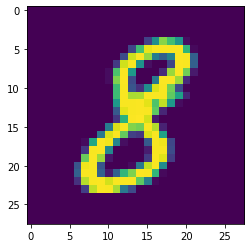

In [485]:
plt.imshow(x_test_selected[2])

In [636]:
my_model = lal.LusiModel(predicates=None, weight_matrix=weight_matrix)
my_model.add_optimizer(tf.keras.optimizers.SGD())

In [586]:

modify_metric = lal.modify_metric

In [637]:
eval_metrics = [modify_metric(tf.keras.metrics.BinaryAccuracy(name="Binary Accuracy"), "pred_and_true"), 
                modify_metric(tf.keras.metrics.FalsePositives(name="False Positives"), "pred_and_true"), 
                modify_metric(tf.keras.metrics.FalseNegatives(name="False Negatives"), "pred_and_true"), 
                modify_metric(tf.keras.metrics.Precision(name="Precision"), "pred_and_true"), 
                modify_metric(tf.keras.metrics.Recall(name="Recall"), "pred_and_true"),
                modify_metric(tf.keras.metrics.Mean(name="Mean"), "loss")
               ]
my_model.evaluate(test_dataset, eval_metrics)

[('Binary Accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.5302419>),
 ('False Positives', <tf.Tensor: shape=(), dtype=float32, numpy=377.0>),
 ('False Negatives', <tf.Tensor: shape=(), dtype=float32, numpy=555.0>),
 ('Precision', <tf.Tensor: shape=(), dtype=float32, numpy=0.51974523>),
 ('Recall', <tf.Tensor: shape=(), dtype=float32, numpy=0.423676>),
 ('Mean', <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)]

In [562]:
eval_metrics[0].reset_state()

#my_model.evaluate(test_dataset, eval_metrics)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [638]:
my_model.train(train_dataset, 10, B, eval_metrics)


Start of epoch 0
Training loss (for one batch) at step 0: -1.0425
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.7104
Seen so far: 6464 samples

Start of epoch 1
Training loss (for one batch) at step 0: -1.0505
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.1994
Seen so far: 6464 samples

Start of epoch 2
Training loss (for one batch) at step 0: -1.2303
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.1529
Seen so far: 6464 samples

Start of epoch 3
Training loss (for one batch) at step 0: -1.0123
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.1392
Seen so far: 6464 samples

Start of epoch 4
Training loss (for one batch) at step 0: -0.6522
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.0871
Seen so far: 6464 samples

Start of epoch 5
Training loss (for one batch) at step 0: -0.5270
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.0409
Seen so far: 6464 sample

In [639]:
for j,e in enumerate(my_model.epoch_train_metrics_results):
    print(f"----- Epoch {j} -----")
    for i in e:
        print(f"{i[0]}: {i[1]}")

----- Epoch 0 -----
Binary Accuracy: 0.52685546875
False Positives: 377.0
False Negatives: 592.0
Precision: 0.5357142686843872
Recall: 0.42356377840042114
Mean: -0.03257717937231064
----- Epoch 1 -----
Binary Accuracy: 0.8444602489471436
False Positives: 1507.0
False Negatives: 683.0
Precision: 0.8026970624923706
Recall: 0.8997651934623718
Mean: -0.00986365508288145
----- Epoch 2 -----
Binary Accuracy: 0.9413855671882629
False Positives: 488.0
False Negatives: 221.0
Precision: 0.9202353954315186
Recall: 0.9622286558151245
Mean: -0.12175240367650986
----- Epoch 3 -----
Binary Accuracy: 0.9608134627342224
False Positives: 382.0
False Negatives: 92.0
Precision: 0.9377951622009277
Recall: 0.9842761754989624
Mean: -0.11836786568164825
----- Epoch 4 -----
Binary Accuracy: 0.9656084775924683
False Positives: 346.0
False Negatives: 70.0
Precision: 0.9435286521911621
Recall: 0.9880362153053284
Mean: -0.11974052339792252
----- Epoch 5 -----
Binary Accuracy: 0.9677579402923584
False Positives: 32

In [592]:
my_model.evaluate(test_dataset, eval_metrics)

[('Binary Accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.8142641>),
 ('False Positives', <tf.Tensor: shape=(), dtype=float32, numpy=526.0>),
 ('False Negatives', <tf.Tensor: shape=(), dtype=float32, numpy=211.0>),
 ('Precision', <tf.Tensor: shape=(), dtype=float32, numpy=0.76632607>),
 ('Recall', <tf.Tensor: shape=(), dtype=float32, numpy=0.8910124>),
 ('Mean', <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)]

In [593]:
my_model.predict(x_test_selected[[22]])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9701108]], dtype=float32)>

In [628]:
for j,e in enumerate(my_model.epoch_train_metrics_results):
    print(f"Epoch {j} \n")
    for i in e:
        print(f"{i[0]}: {i[1]}")

Epoch 0 

Binary Accuracy: 0.8071733117103577
False Positives: 2014.0
False Negatives: 701.0
Precision: 0.7523059844970703
Recall: 0.897183895111084
Mean: 0.0200845655053854
Epoch 1 

Binary Accuracy: 0.9328703880310059
False Positives: 508.0
False Negatives: 304.0
Precision: 0.916102409362793
Recall: 0.9480430483818054
Mean: -0.10966261476278305
Epoch 2 

Binary Accuracy: 0.9653604626655579
False Positives: 321.0
False Negatives: 98.0
Precision: 0.947151780128479
Recall: 0.9832507371902466
Mean: -0.11335418373346329
Epoch 3 

Binary Accuracy: 0.9695767164230347
False Positives: 289.0
False Negatives: 79.0
Precision: 0.9523180723190308
Recall: 0.9864980578422546
Mean: -0.11480322480201721
Epoch 4 

Binary Accuracy: 0.9718088507652283
False Positives: 265.0
False Negatives: 76.0
Precision: 0.9561258554458618
Recall: 0.9870107769966125
Mean: -0.11239594966173172
Epoch 5 

Binary Accuracy: 0.9728835821151733
False Positives: 251.0
False Negatives: 77.0
Precision: 0.9583402276039124
Recall

In [613]:
mets = my_model.epoch_train_metrics_results

In [617]:
mets[0][0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.93382716>

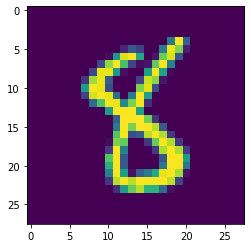

In [594]:
plt.imshow(x_test_selected[22])